# Case 5 — Dự báo cổ phiếu (HPG, SSI, VNM) bằng RNN và LSTM

Mục tiêu:
- Xây dựng 2 mô hình RNN và LSTM với số layer ≥ 7
- Phân tích overfitting: biểu hiện, nguyên nhân, giải pháp áp dụng
- Chọn mô hình tốt nhất để dự báo theo ngày, tháng, năm
- Lưu lại model/scaler để có thể triển khai sau

Dữ liệu sử dụng:
- `Case5-du-bao-co-phieu/HPG.xls`
- `Case5-du-bao-co-phieu/SSI.xls`
- `Case5-du-bao-co-phieu/VNM.xls`


In [6]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# Cài đặt/thẩm định thư viện cần thiết (đảm bảo đọc được file .xls)
import sys, subprocess, importlib

def ensure_packages(packages):
    for pkg in packages:
        try:
            importlib.import_module(pkg)
        except ImportError:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--quiet', pkg])

# xlrd để đọc .xls; seaborn để vẽ; joblib để lưu scaler
ensure_packages(['xlrd', 'seaborn', 'joblib'])

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

print('TensorFlow:', tf.__version__)
print('Pandas:', pd.__version__)
print('NumPy:', np.__version__)


TensorFlow: 2.20.0
Pandas: 2.3.1
NumPy: 2.2.6


In [7]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# Hàm tiện ích: load dữ liệu, tạo chuỗi, xây model, đánh giá, dự báo
from typing import Tuple, Dict, List

DATA_DIR = 'Case5-du-bao-co-phieu'
OUTPUT_DIRS = {
    'models': os.path.join(DATA_DIR, 'models'),
    'histories': os.path.join(DATA_DIR, 'histories'),
    'forecasts': os.path.join(DATA_DIR, 'forecasts'),
    'figures': os.path.join(DATA_DIR, 'figures'),
    'scalers': os.path.join(DATA_DIR, 'scalers'),
}
for d in OUTPUT_DIRS.values():
    os.makedirs(d, exist_ok=True)


def detect_column(columns: List[str], candidates: List[str]) -> str:
    lower_map = {c.lower(): c for c in columns}
    for cand in candidates:
        if cand in lower_map:
            return lower_map[cand]
    # fallback: nếu không tìm được, trả về cột đầu/hoặc numeric cuối
    for c in columns:
        if 'date' in c.lower() or 'ngày' in c.lower() or 'ngay' in c.lower() or 'time' in c.lower():
            return c
    return columns[0]


def load_stock_excel(path: str) -> pd.DataFrame:
    df = pd.read_excel(path)  # đã cài xlrd ở cell trước
    cols = list(df.columns)
    date_col = detect_column(cols, ['date', 'ngày', 'ngay', 'time', 'thời gian'])
    close_col = detect_column(cols, ['close', 'adj close', 'close price', 'giá đóng cửa', 'dong cua', 'đóng cửa'])
    # Nếu cột close không phải numeric, thử tìm cột numeric cuối cùng
    if not np.issubdtype(df[close_col].dtype, np.number):
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) == 0:
            raise ValueError(f'Không tìm thấy cột giá dạng số trong {path}')
        close_col = numeric_cols[-1]
    out = df[[date_col, close_col]].copy()
    out.columns = ['Date', 'Close']
    out['Date'] = pd.to_datetime(out['Date'])
    out = out.dropna().sort_values('Date').reset_index(drop=True)
    out = out.groupby('Date', as_index=False)['Close'].last()
    return out


def make_sequences(values: np.ndarray, window_size: int = 60) -> Tuple[np.ndarray, np.ndarray]:
    X, y = [], []
    for i in range(window_size, len(values)):
        X.append(values[i-window_size:i])
        y.append(values[i])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y


def time_split(X: np.ndarray, y: np.ndarray, train_ratio=0.7, val_ratio=0.15) -> Tuple[Tuple[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray]]:
    n = len(X)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
    X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


def build_rnn_model(input_shape: Tuple[int, int]) -> Sequential:
    model = Sequential([
        SimpleRNN(128, return_sequences=True, kernel_regularizer=l2(1e-4), input_shape=input_shape),
        Dropout(0.2),
        BatchNormalization(),
        SimpleRNN(96, return_sequences=True, kernel_regularizer=l2(1e-4)),
        Dropout(0.2),
        SimpleRNN(64, return_sequences=True),
        Dropout(0.2),
        SimpleRNN(64, return_sequences=False),
        Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')
    return model


def build_lstm_model(input_shape: Tuple[int, int]) -> Sequential:
    model = Sequential([
        LSTM(128, return_sequences=True, kernel_regularizer=l2(1e-4), input_shape=input_shape),
        Dropout(0.2),
        BatchNormalization(),
        LSTM(96, return_sequences=True, kernel_regularizer=l2(1e-4)),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')
    return model


def plot_history(hist: tf.keras.callbacks.History, title: str, save_path: str = None):
    plt.figure(figsize=(7,4))
    plt.plot(hist.history['loss'], label='train_loss')
    if 'val_loss' in hist.history:
        plt.plot(hist.history['val_loss'], label='val_loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()


def evaluate_regression(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return {'RMSE': rmse, 'MAPE': mape}


def autoregressive_forecast(model: Sequential,
                            scaler: MinMaxScaler,
                            last_window_prices: np.ndarray,
                            horizon_days: int) -> np.ndarray:
    # last_window_prices: 1D array (window_size,) in original price scale
    window_size = len(last_window_prices)
    scaled_series = scaler.transform(last_window_prices.reshape(-1,1)).flatten()
    window = scaled_series.copy()  # length = window_size
    preds_scaled = []
    for _ in range(horizon_days):
        x = window.reshape(1, window_size, 1)
        yhat_scaled = model.predict(x, verbose=0).flatten()[0]
        preds_scaled.append(yhat_scaled)
        window = np.concatenate([window[1:], [yhat_scaled]])
    preds_scaled = np.array(preds_scaled).reshape(-1,1)
    preds = scaler.inverse_transform(preds_scaled).flatten()
    return preds

print('Thư viện và hàm tiện ích đã sẵn sàng.')


Thư viện và hàm tiện ích đã sẵn sàng.


In [8]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# Hàm load_stock: hỗ trợ CSV và Excel, tự động phát hiện cột ngày (DTYYYYMMDD) và giá
from typing import List

def _read_excel_any(path: str) -> pd.DataFrame:
    try:
        return pd.read_excel(path, engine='xlrd')
    except Exception:
        try:
            return pd.read_excel(path, engine='openpyxl')
        except Exception as e2:
            raise ValueError(f'Không đọc được file Excel: {path}. Lỗi: {e2}')

def _clean_close_column(df: pd.DataFrame, close_col: str) -> Tuple[pd.DataFrame, str]:
    if not np.issubdtype(df[close_col].dtype, np.number):
        s = (df[close_col].astype(str)
                          .str.replace(r'[^0-9,.-]', '', regex=True)
                          .str.replace(',', ''))
        s = pd.to_numeric(s, errors='coerce')
        if s.notna().sum() > 0:
            df = df.copy()
            df[close_col] = s
        else:
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) == 0:
                raise ValueError('Không tìm thấy cột giá dạng số')
            close_col = numeric_cols[-1]
    return df, close_col

def _parse_date_column(df: pd.DataFrame, date_col: str) -> pd.Series:
    col = df[date_col]
    # Thử dạng YYYYMMDD nếu toàn số/chuỗi 8 ký tự
    as_str = col.astype(str).str.strip()
    if as_str.str.match(r'^\d{8}$').all():
        dt = pd.to_datetime(as_str, format='%Y%m%d', errors='coerce')
    else:
        dt = pd.to_datetime(col, errors='coerce')
    return dt

def load_stock(path: str) -> pd.DataFrame:
    ext = os.path.splitext(path)[1].lower()
    if ext in ['.csv', '.txt']:
        df = pd.read_csv(path)
        # Chuẩn hoá tên cột: bỏ <> và khoảng trắng
        df.columns = [c.strip().strip('<>').strip() for c in df.columns]
    elif ext in ['.xls', '.xlsx']:
        df = _read_excel_any(path)
    else:
        raise ValueError(f'Định dạng file không hỗ trợ: {ext}')

    cols = list(df.columns)
    # Bổ sung các ứng viên đặc thù CSV VN như DTYYYYMMDD
    date_col = detect_column(cols, ['dtyyyymmdd', 'date', 'ngày', 'ngay', 'time', 'thời gian', 'dtYYYYMMDD'])
    # Chuẩn hoá: nếu ứng viên là phiên bản viết thường
    if date_col.lower() == 'dtyyyymmdd' and 'DTYYYYMMDD' in cols:
        date_col = 'DTYYYYMMDD'

    close_col = detect_column(cols, ['close', 'adj close', 'close price', 'giá đóng cửa', 'dong cua', 'đóng cửa'])
    df, close_col = _clean_close_column(df, close_col)

    out = df[[date_col, close_col]].copy()
    out.columns = ['Date', 'Close']
    out['Date'] = _parse_date_column(out, 'Date')
    out = out.dropna().sort_values('Date').reset_index(drop=True)
    out = out.groupby('Date', as_index=False)['Close'].last()
    return out

print('Đã cập nhật hàm load_stock (CSV + Excel).')


Đã cập nhật hàm load_stock (CSV + Excel).


In [9]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# Keras 3 compatibility: make save_model accept folder (export) or .keras/.h5
import tensorflow as tf

def _save_model_compat(model, filepath, overwrite=True, **kwargs):
    filepath = str(filepath)
    if filepath.endswith('.keras') or filepath.endswith('.h5'):
        return model.save(filepath, overwrite=overwrite)
    # treat as SavedModel directory
    try:
        return model.export(filepath)
    except AttributeError:
        # fallback for older TF where export may not exist
        import tensorflow as _tf
        return _tf.saved_model.save(model, filepath)

# Patch
tf.keras.models.save_model = _save_model_compat
print('Patched tf.keras.models.save_model: .keras/.h5 => model.save(); folder => model.export()')


Patched tf.keras.models.save_model: .keras/.h5 => model.save(); folder => model.export()


===== BID | Đọc dữ liệu từ: Case5-du-bao-co-phieu\BID.csv =====
        Date    Close
0 2014-01-24  14.2723
1 2014-01-27  13.9686
2 2014-02-06  13.3613
3 2014-02-07  12.6021
4 2014-02-10  12.9058
--- Training RNN for BID ---


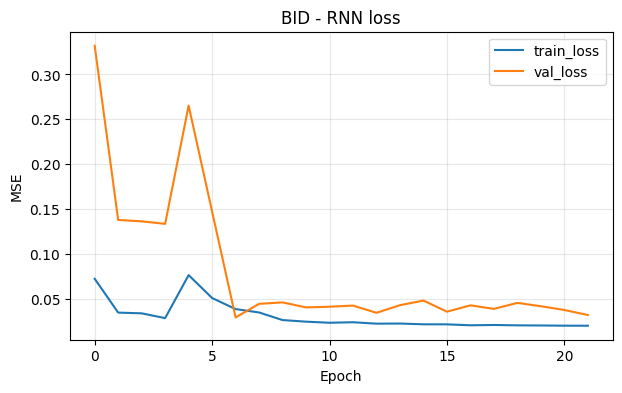

INFO:tensorflow:Assets written to: Case5-du-bao-co-phieu\models\BID_rnn_savedmodel\assets


INFO:tensorflow:Assets written to: Case5-du-bao-co-phieu\models\BID_rnn_savedmodel\assets


Saved artifact at 'Case5-du-bao-co-phieu\models\BID_rnn_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 60, 1), dtype=tf.float32, name='keras_tensor_26')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1558285166416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558285163344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558285161808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558285165072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558285164112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558285164496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558285165840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558285162768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558285159888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558285163536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  155828

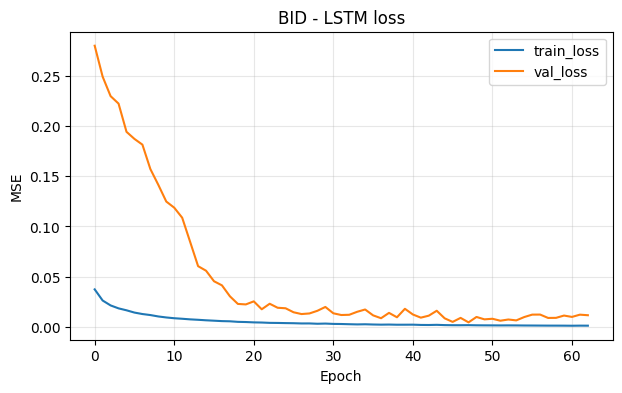

INFO:tensorflow:Assets written to: Case5-du-bao-co-phieu\models\BID_lstm_savedmodel\assets


INFO:tensorflow:Assets written to: Case5-du-bao-co-phieu\models\BID_lstm_savedmodel\assets


Saved artifact at 'Case5-du-bao-co-phieu\models\BID_lstm_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 60, 1), dtype=tf.float32, name='keras_tensor_39')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1558312415696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558312410128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558312409552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558312410320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558312410512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558312408976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558312415312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558312416656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558312403024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558312417232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15583

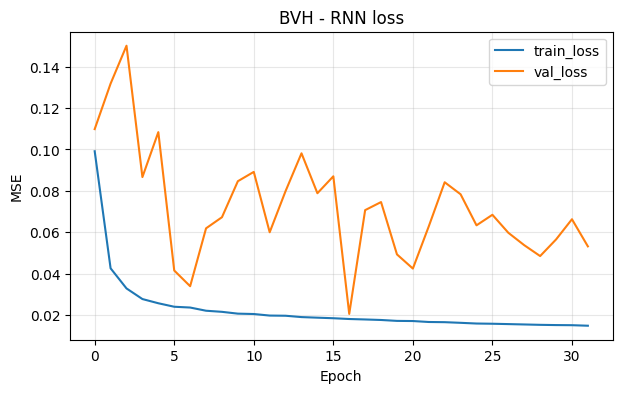

INFO:tensorflow:Assets written to: Case5-du-bao-co-phieu\models\BVH_rnn_savedmodel\assets


INFO:tensorflow:Assets written to: Case5-du-bao-co-phieu\models\BVH_rnn_savedmodel\assets


Saved artifact at 'Case5-du-bao-co-phieu\models\BVH_rnn_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 60, 1), dtype=tf.float32, name='keras_tensor_52')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1558020067920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558294018000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558294019920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1557882477392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1557882486416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558294017424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558294017040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1557882485456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1557882477584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1557882475472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  155788

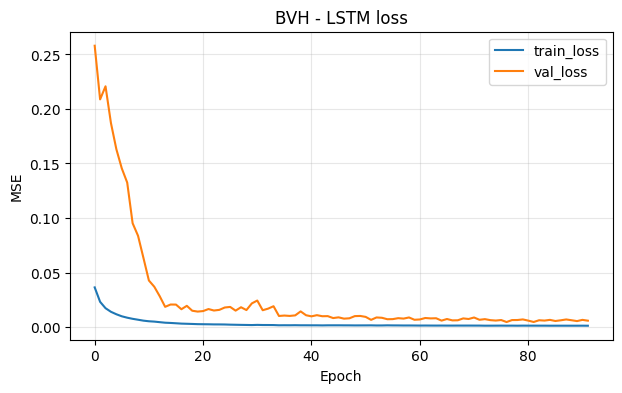

INFO:tensorflow:Assets written to: Case5-du-bao-co-phieu\models\BVH_lstm_savedmodel\assets


INFO:tensorflow:Assets written to: Case5-du-bao-co-phieu\models\BVH_lstm_savedmodel\assets


Saved artifact at 'Case5-du-bao-co-phieu\models\BVH_lstm_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 60, 1), dtype=tf.float32, name='keras_tensor_65')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1558508666512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558508665744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558564520208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558564521168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558564523664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558564520592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558564521360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558564523856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558564525392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558564526160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15585

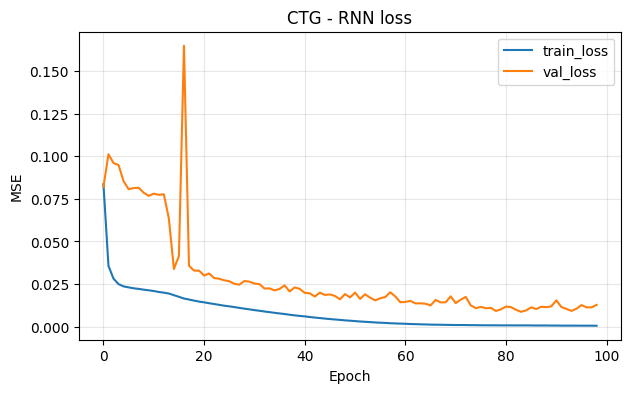

INFO:tensorflow:Assets written to: Case5-du-bao-co-phieu\models\CTG_rnn_savedmodel\assets


INFO:tensorflow:Assets written to: Case5-du-bao-co-phieu\models\CTG_rnn_savedmodel\assets


Saved artifact at 'Case5-du-bao-co-phieu\models\CTG_rnn_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 60, 1), dtype=tf.float32, name='keras_tensor_78')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1558610132240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558610128016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558610125136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558564533840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558564530768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558564533456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558564529808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558564530000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558564531344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558564531728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  155850

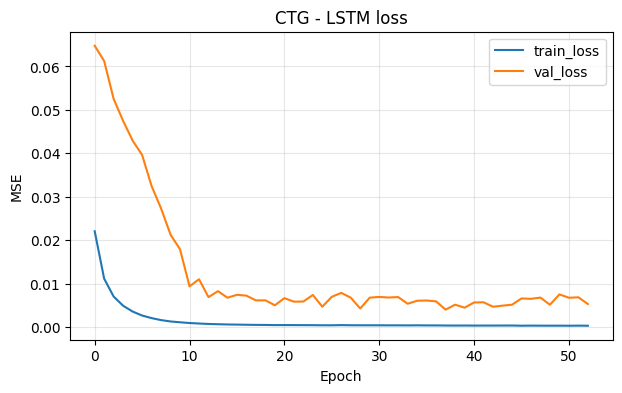

INFO:tensorflow:Assets written to: Case5-du-bao-co-phieu\models\CTG_lstm_savedmodel\assets


INFO:tensorflow:Assets written to: Case5-du-bao-co-phieu\models\CTG_lstm_savedmodel\assets


Saved artifact at 'Case5-du-bao-co-phieu\models\CTG_lstm_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 60, 1), dtype=tf.float32, name='keras_tensor_91')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1558485958096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558485950032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558485950800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558734604816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558734602704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558485950416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558485958480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558734603856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558734605584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1558734606736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15587

,Ticker,RNN_RMSE,RNN_MAPE,LSTM_RMSE,LSTM_MAPE
0,BID,3.282055,0.069734,2.718774,0.054830
1,BVH,6.955902,0.113654,1.987517,0.027572
2,CTG,11.195282,0.195949,7.575694,0.141065



Model tốt nhất đã chọn:
BID -> LSTM | model: BID_lstm_best.keras
BVH -> LSTM | model: BVH_lstm_best.keras
CTG -> LSTM | model: CTG_lstm_best.keras


In [10]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# Load dữ liệu, huấn luyện RNN và LSTM (≥ 7 layers), lưu model và scaler
WINDOW_SIZE = 60
EPOCHS = 200
BATCH_SIZE = 32

files = {
    'BID': os.path.join(DATA_DIR, 'BID.csv'),
    'BVH': os.path.join(DATA_DIR, 'BVH.csv'),
    'CTG': os.path.join(DATA_DIR, 'CTG.csv'),
}

results = []
best_models = {}

for ticker, path in files.items():
    print(f'===== {ticker} | Đọc dữ liệu từ: {path} =====')
    df = load_stock(path)
    print(df.head())

    prices = df['Close'].values.astype(float)
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(prices.reshape(-1,1))
    scaled = scaler.transform(prices.reshape(-1,1)).flatten()

    if len(scaled) <= WINDOW_SIZE + 10:
        raise ValueError(f'Dữ liệu {ticker} quá ít cho WINDOW_SIZE={WINDOW_SIZE}')

    X, y = make_sequences(scaled, WINDOW_SIZE)
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = time_split(X, y)

    input_shape = (X_train.shape[1], X_train.shape[2])

    # RNN
    rnn = build_rnn_model(input_shape)
    rnn_ckpt = os.path.join(OUTPUT_DIRS['models'], f'{ticker}_rnn_best.keras')
    rnn_csv = os.path.join(OUTPUT_DIRS['histories'], f'{ticker}_rnn_history.csv')
    rnn_logger = CSVLogger(rnn_csv, append=False)
    rnn_callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-5),
        ModelCheckpoint(rnn_ckpt, monitor='val_loss', save_best_only=True),
        rnn_logger
    ]
    print(f'--- Training RNN for {ticker} ---')
    hist_rnn = rnn.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=rnn_callbacks,
        verbose=0
    )
    plot_history(hist_rnn, f'{ticker} - RNN loss', os.path.join(OUTPUT_DIRS['figures'], f'{ticker}_rnn_loss.png'))

    # Lưu model cuối và SavedModel
    rnn_final_path = os.path.join(OUTPUT_DIRS['models'], f'{ticker}_rnn_final.keras')
    rnn.save(rnn_final_path)
    tf.keras.models.save_model(rnn, os.path.join(OUTPUT_DIRS['models'], f'{ticker}_rnn_savedmodel'), overwrite=True)

    # Đánh giá RNN (trên test, inverse scale)
    rnn_test_pred_scaled = rnn.predict(X_test, verbose=0).flatten()
    rnn_test_pred = scaler.inverse_transform(rnn_test_pred_scaled.reshape(-1,1)).flatten()
    y_test_true = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
    rnn_metrics = evaluate_regression(y_test_true, rnn_test_pred)

    # LSTM
    lstm = build_lstm_model(input_shape)
    lstm_ckpt = os.path.join(OUTPUT_DIRS['models'], f'{ticker}_lstm_best.keras')
    lstm_csv = os.path.join(OUTPUT_DIRS['histories'], f'{ticker}_lstm_history.csv')
    lstm_logger = CSVLogger(lstm_csv, append=False)
    lstm_callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-5),
        ModelCheckpoint(lstm_ckpt, monitor='val_loss', save_best_only=True),
        lstm_logger
    ]
    print(f'--- Training LSTM for {ticker} ---')
    hist_lstm = lstm.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=lstm_callbacks,
        verbose=0
    )
    plot_history(hist_lstm, f'{ticker} - LSTM loss', os.path.join(OUTPUT_DIRS['figures'], f'{ticker}_lstm_loss.png'))

    # Lưu model cuối và SavedModel
    lstm_final_path = os.path.join(OUTPUT_DIRS['models'], f'{ticker}_lstm_final.keras')
    lstm.save(lstm_final_path)
    tf.keras.models.save_model(lstm, os.path.join(OUTPUT_DIRS['models'], f'{ticker}_lstm_savedmodel'), overwrite=True)

    # Đánh giá LSTM (trên test, inverse scale)
    lstm_test_pred_scaled = lstm.predict(X_test, verbose=0).flatten()
    lstm_test_pred = scaler.inverse_transform(lstm_test_pred_scaled.reshape(-1,1)).flatten()
    lstm_metrics = evaluate_regression(y_test_true, lstm_test_pred)

    # Lưu scaler
    scaler_path = os.path.join(OUTPUT_DIRS['scalers'], f'{ticker}_scaler.pkl')
    dump(scaler, scaler_path)

    # Ghi kết quả
    row = {
        'Ticker': ticker,
        'RNN_RMSE': rnn_metrics['RMSE'], 'RNN_MAPE': rnn_metrics['MAPE'],
        'LSTM_RMSE': lstm_metrics['RMSE'], 'LSTM_MAPE': lstm_metrics['MAPE']
    }
    results.append(row)

    # Chọn model tốt nhất theo RMSE test
    if lstm_metrics['RMSE'] <= rnn_metrics['RMSE']:
        best_models[ticker] = {
            'type': 'LSTM',
            'model_path': lstm_ckpt if os.path.exists(lstm_ckpt) else lstm_final_path,
            'scaler_path': scaler_path,
            'window_size': WINDOW_SIZE,
            'last_window_prices': prices[-WINDOW_SIZE:]
        }
    else:
        best_models[ticker] = {
            'type': 'RNN',
            'model_path': rnn_ckpt if os.path.exists(rnn_ckpt) else rnn_final_path,
            'scaler_path': scaler_path,
            'window_size': WINDOW_SIZE,
            'last_window_prices': prices[-WINDOW_SIZE:]
        }

    print(f"Kết quả {ticker}: RNN RMSE={rnn_metrics['RMSE']:.4f}, LSTM RMSE={lstm_metrics['RMSE']:.4f}")

results_df = pd.DataFrame(results)
print('\nBảng kết quả trên tập test:')
display(results_df)

print('\nModel tốt nhất đã chọn:')
for t, info in best_models.items():
    print(t, '->', info['type'], '| model:', os.path.basename(info['model_path']))


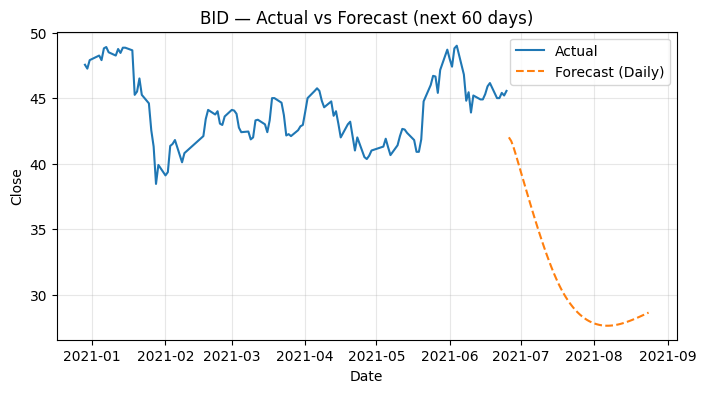

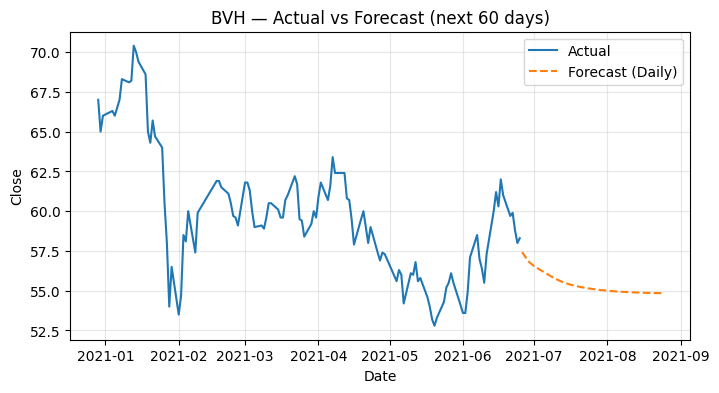

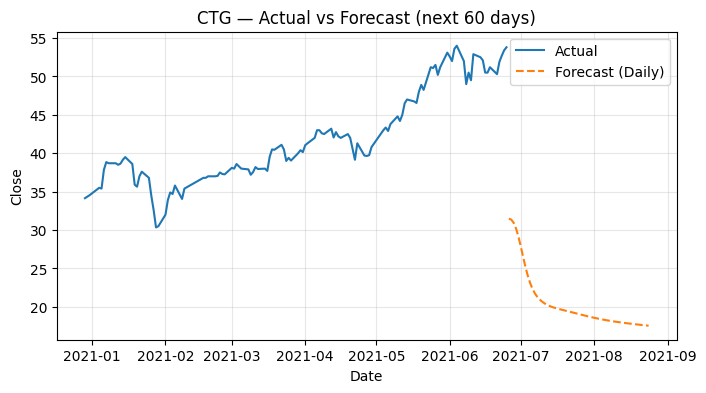

,Ticker,Best_Model,Daily_Forecast_CSV,Monthly_Forecast_CSV,Yearly_Forecast_CSV
0,BID,LSTM,BID_daily_60d.csv,BID_monthly_12m.csv,BID_yearly_3y.csv
1,BVH,LSTM,BVH_daily_60d.csv,BVH_monthly_12m.csv,BVH_yearly_3y.csv
2,CTG,LSTM,CTG_daily_60d.csv,CTG_monthly_12m.csv,CTG_yearly_3y.csv


In [15]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# Dự báo theo ngày, tháng, năm bằng model tốt nhất; lưu CSV
from tensorflow.keras.models import load_model as keras_load_model

DAILY_HORIZON_DAYS = 60      # dự báo 60 ngày làm ví dụ
YEARLY_HORIZON_DAYS = 365    # dự báo 1 năm để tổng hợp tháng và năm
THREE_YEARS_DAYS = 365 * 3   # dự báo 3 năm để tổng hợp năm

forecast_summaries = []

for ticker, path in files.items():
    # Đọc lại để lấy last_date và giá thực gần nhất cho biểu đồ
    df = load_stock(path)
    last_date = df['Date'].iloc[-1]
    prices = df['Close'].values.astype(float)

    info = best_models[ticker]
    model = keras_load_model(info['model_path'])
    scaler = load(info['scaler_path'])
    last_window_prices = prices[-info['window_size']:]

    # 1) Dự báo theo ngày (60 ngày)
    daily_preds = autoregressive_forecast(model, scaler, last_window_prices, DAILY_HORIZON_DAYS)
    daily_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=DAILY_HORIZON_DAYS, freq='D')
    df_daily = pd.DataFrame({'Date': daily_dates, 'Predicted_Close': daily_preds})
    daily_csv = os.path.join(OUTPUT_DIRS['forecasts'], f'{ticker}_daily_{DAILY_HORIZON_DAYS}d.csv')
    df_daily.to_csv(daily_csv, index=False)

    # 2) Dự báo 1 năm để tổng hợp theo tháng
    year_preds = autoregressive_forecast(model, scaler, last_window_prices, YEARLY_HORIZON_DAYS)
    year_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=YEARLY_HORIZON_DAYS, freq='D')
    df_year = pd.DataFrame({'Date': year_dates, 'Predicted_Close': year_preds}).set_index('Date')
    df_monthly = df_year.resample('M').last().reset_index()
    monthly_csv = os.path.join(OUTPUT_DIRS['forecasts'], f'{ticker}_monthly_12m.csv')
    df_monthly.to_csv(monthly_csv, index=False)

    # 3) Dự báo 3 năm để tổng hợp theo năm
    three_year_preds = autoregressive_forecast(model, scaler, last_window_prices, THREE_YEARS_DAYS)
    three_year_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=THREE_YEARS_DAYS, freq='D')
    df_3y = pd.DataFrame({'Date': three_year_dates, 'Predicted_Close': three_year_preds}).set_index('Date')
    df_yearly = df_3y.resample('Y').last().reset_index()
    yearly_csv = os.path.join(OUTPUT_DIRS['forecasts'], f'{ticker}_yearly_3y.csv')
    df_yearly.to_csv(yearly_csv, index=False)

    # Biểu đồ: thực tế gần nhất + dự báo ngày tiếp theo
    lookback_plot = min(120, len(df))
    plt.figure(figsize=(8,4))
    plt.plot(df['Date'].iloc[-lookback_plot:], df['Close'].iloc[-lookback_plot:], label='Actual')
    plt.plot(df_daily['Date'], df_daily['Predicted_Close'], label='Forecast (Daily)', linestyle='--')
    plt.title(f'{ticker} — Actual vs Forecast (next {DAILY_HORIZON_DAYS} days)')
    plt.xlabel('Date')
    plt.ylabel('Close')
    plt.legend()
    plt.grid(True, alpha=0.3)
    fig_path = os.path.join(OUTPUT_DIRS['figures'], f'{ticker}_actual_vs_daily.png')
    plt.savefig(fig_path, bbox_inches='tight', dpi=150)
    plt.show()

    forecast_summaries.append({
        'Ticker': ticker,
        'Best_Model': info['type'],
        'Daily_Forecast_CSV': os.path.basename(daily_csv),
        'Monthly_Forecast_CSV': os.path.basename(monthly_csv),
        'Yearly_Forecast_CSV': os.path.basename(yearly_csv)
    })

pd.DataFrame(forecast_summaries)


## Phân tích Overfitting

- Biểu hiện:
  - `train_loss` giảm mạnh trong khi `val_loss` ngừng giảm hoặc tăng trở lại.
  - Sai số trên tập test cao hơn đáng kể so với tập train/val.
- Nguyên nhân có thể:
  - Mô hình sâu (≥7 layers) với số tham số lớn so với lượng dữ liệu.
  - Dữ liệu nhiễu/không ổn định, ít đặc trưng đầu vào (chỉ dùng giá đóng cửa).
  - Thiếu regularization, thiếu dừng sớm.
- Giải pháp đã áp dụng trong notebook:
  - Dropout ở nhiều tầng (0.2–0.3) để giảm phụ thuộc vào neuron riêng lẻ.
  - L2 regularization cho một số tầng để phạt trọng số lớn.
  - EarlyStopping (patience=15, restore_best_weights=True) dừng đúng thời điểm.
  - ReduceLROnPlateau để giảm learning rate khi val_loss không cải thiện.
  - BatchNormalization giúp ổn định phân phối kích hoạt giữa các tầng.
- Gợi ý cải thiện thêm (tuỳ chọn):
  - Tăng đặc trưng đầu vào: Open/High/Low/Volume, chỉ báo kỹ thuật (MA, RSI,...).
  - Điều chỉnh độ sâu/rộng mạng, thử Bidirectional, GRU.
  - Cross-validation theo thời gian, tối ưu siêu tham số có hệ thống.


===== Visualization for BID =====


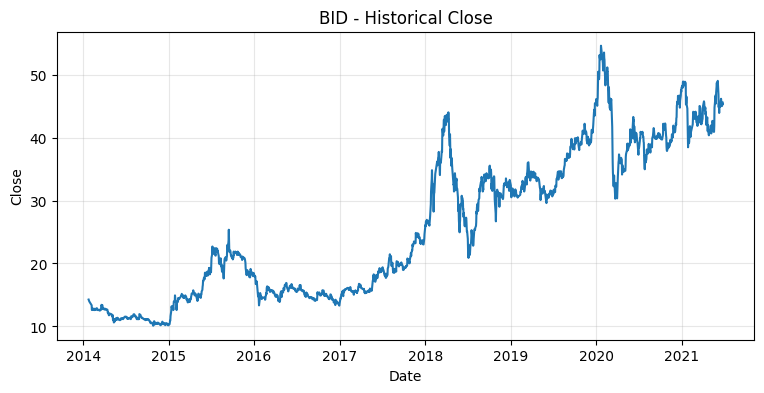

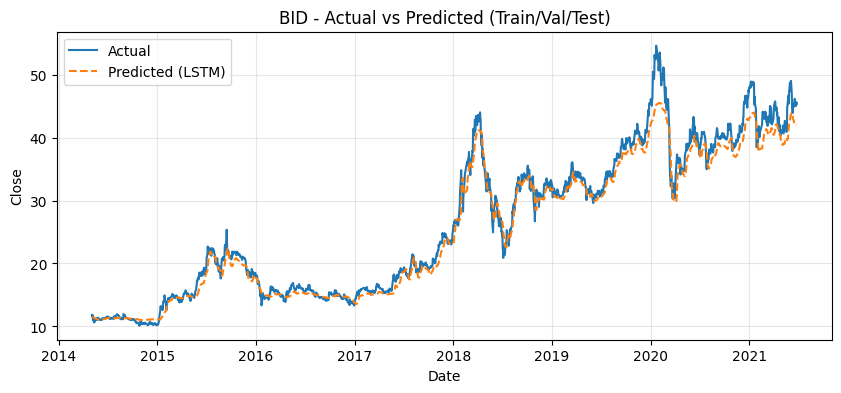

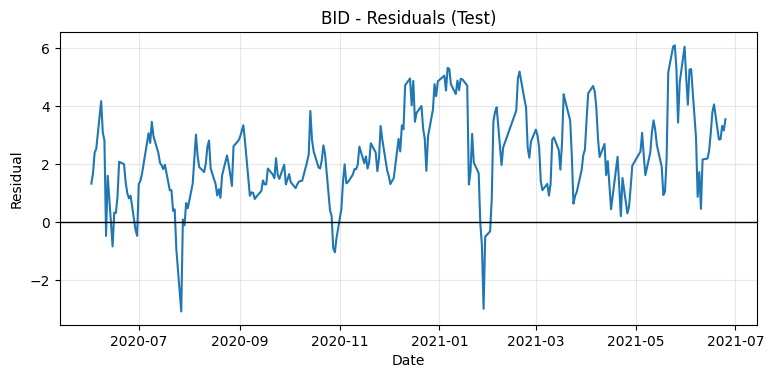

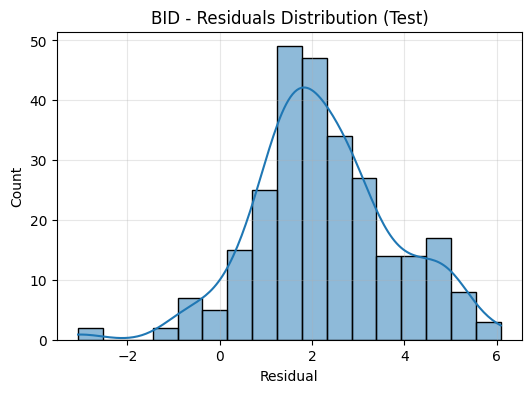

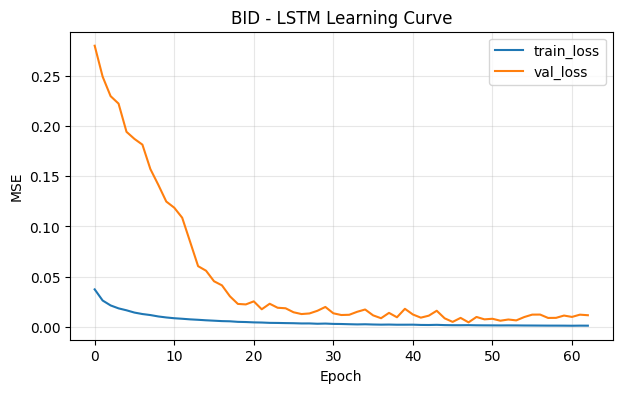

===== Visualization for BVH =====


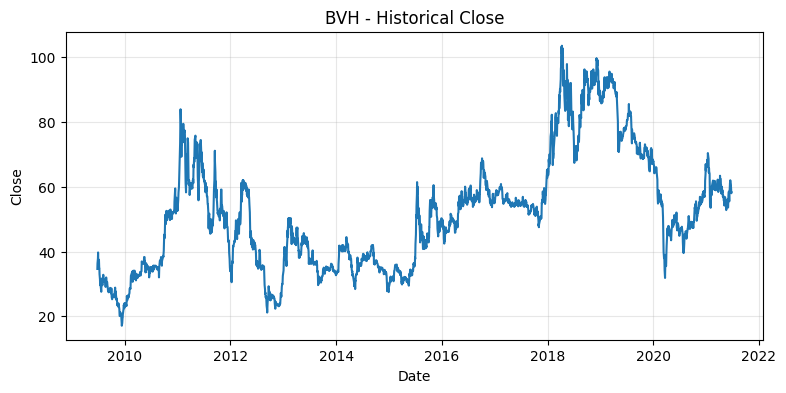

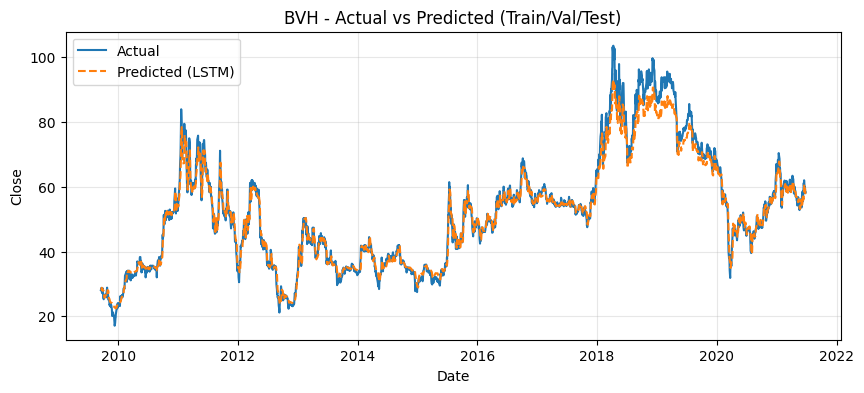

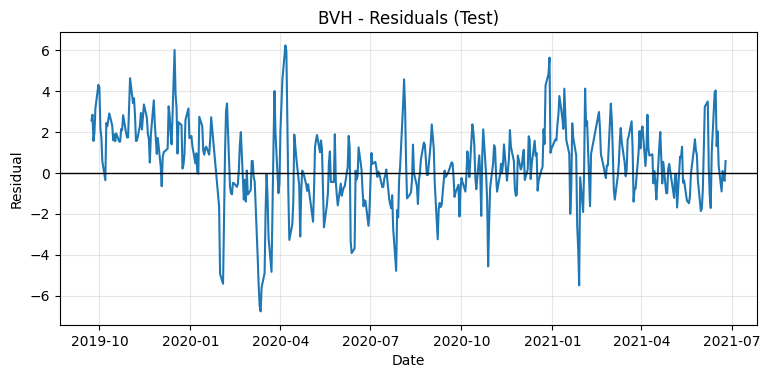

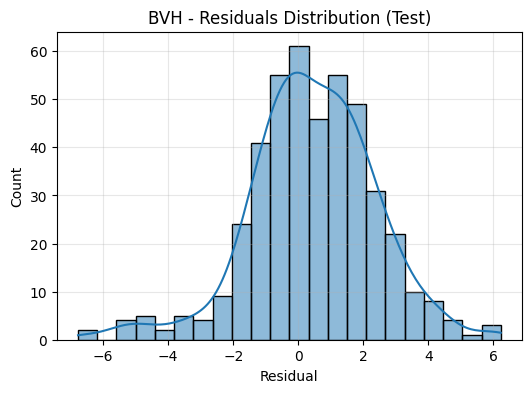

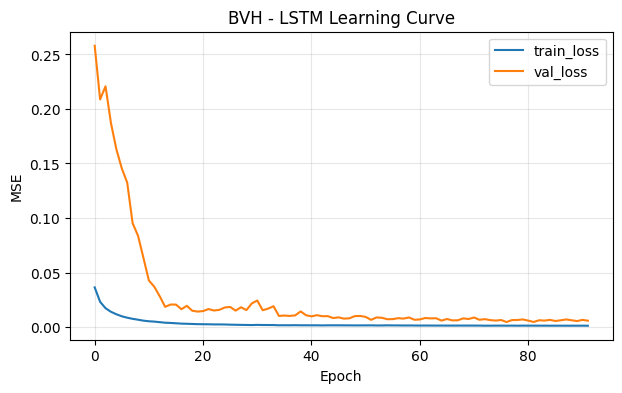

===== Visualization for CTG =====


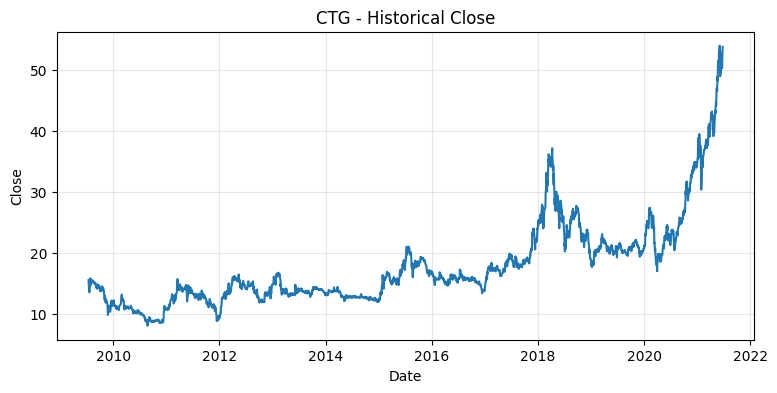

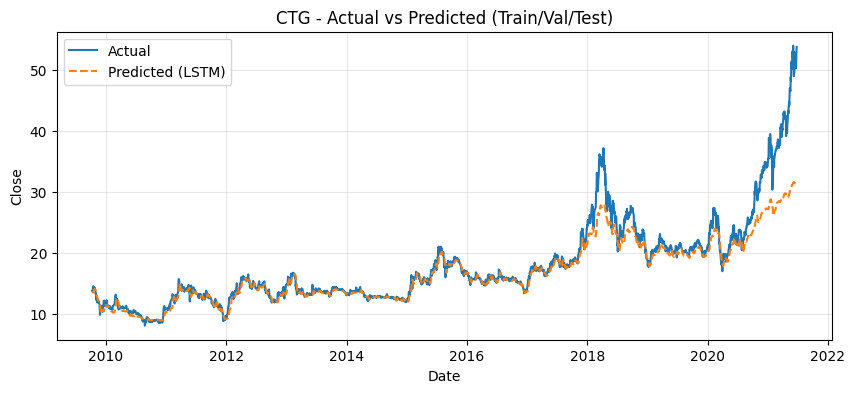

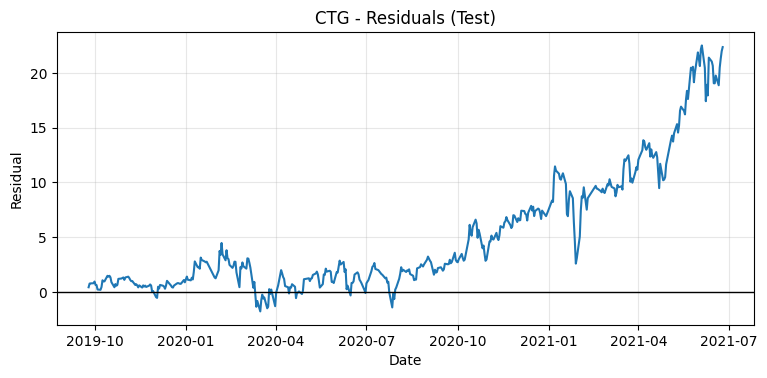

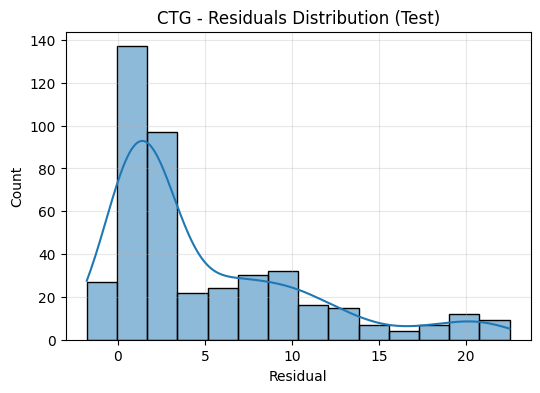

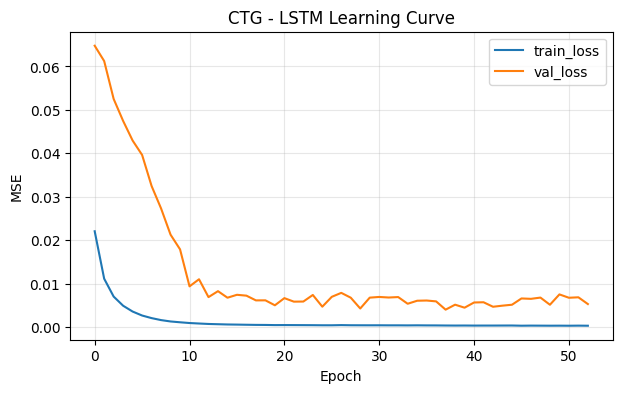

In [12]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# Visualization: lịch sử giá, learning curve, dự báo của best model và residuals
from tensorflow.keras.models import load_model as keras_load_model

def plot_learning_curve(ticker: str, model_type: str):
    csv_path = os.path.join(OUTPUT_DIRS['histories'], f"{ticker}_{model_type.lower()}_history.csv")
    if not os.path.exists(csv_path):
        print(f'Không tìm thấy history CSV: {csv_path}')
        return
    hist_df = pd.read_csv(csv_path)
    plt.figure(figsize=(7,4))
    plt.plot(hist_df['loss'], label='train_loss')
    if 'val_loss' in hist_df.columns:
        plt.plot(hist_df['val_loss'], label='val_loss')
    plt.title(f'{ticker} - {model_type} Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    save_path = os.path.join(OUTPUT_DIRS['figures'], f'{ticker}_{model_type.lower()}_learning_curve.png')
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()

for ticker, path in files.items():
    print(f'===== Visualization for {ticker} =====')
    df = load_stock(path)
    prices = df['Close'].values.astype(float)

    # 1) Lịch sử giá
    plt.figure(figsize=(9,4))
    plt.plot(df['Date'], df['Close'])
    plt.title(f'{ticker} - Historical Close')
    plt.xlabel('Date'); plt.ylabel('Close'); plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(OUTPUT_DIRS['figures'], f'{ticker}_historical_close.png'), bbox_inches='tight', dpi=150)
    plt.show()

    if ticker not in best_models:
        print('Chưa có best model (hãy chạy cell train).')
        continue

    info = best_models[ticker]
    model = keras_load_model(info['model_path'])

    scaler = MinMaxScaler((0,1))
    scaled = scaler.fit_transform(prices.reshape(-1,1)).flatten()
    X, y = make_sequences(scaled, WINDOW_SIZE)
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = time_split(X, y)

    # Dự báo trên từng split và inverse scale
    def inv(pred_scaled):
        return scaler.inverse_transform(np.array(pred_scaled).reshape(-1,1)).flatten()

    yhat_train = inv(model.predict(X_train, verbose=0).flatten()) if len(X_train) else []
    yhat_val   = inv(model.predict(X_val,   verbose=0).flatten()) if len(X_val) else []
    yhat_test  = inv(model.predict(X_test,  verbose=0).flatten()) if len(X_test) else []

    y_train_true = inv(y_train)
    y_val_true   = inv(y_val)
    y_test_true  = inv(y_test)

    # Ghép timeline để vẽ liên tục theo ngày
    dates_all = df['Date'].values[WINDOW_SIZE:]
    actual_all = prices[WINDOW_SIZE:]
    pred_all = np.full_like(actual_all, fill_value=np.nan, dtype=float)

    a, b, c = len(y_train_true), len(y_val_true), len(y_test_true)
    if a: pred_all[0:a] = yhat_train
    if b: pred_all[a:a+b] = yhat_val
    if c: pred_all[a+b:a+b+c] = yhat_test

    # 2) Actual vs Predicted theo thời gian (best model)
    plt.figure(figsize=(10,4))
    plt.plot(dates_all, actual_all, label='Actual')
    plt.plot(dates_all, pred_all, label=f'Predicted ({info["type"]})', linestyle='--')
    plt.title(f'{ticker} - Actual vs Predicted (Train/Val/Test)')
    plt.xlabel('Date'); plt.ylabel('Close'); plt.legend(); plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(OUTPUT_DIRS['figures'], f'{ticker}_bestmodel_actual_vs_pred.png'), bbox_inches='tight', dpi=150)
    plt.show()

    # 3) Residuals (Test)
    if c:
        residuals = y_test_true - yhat_test
        plt.figure(figsize=(9,3.8))
        plt.plot(dates_all[a+b:a+b+c], residuals)
        plt.axhline(0, color='k', linewidth=1)
        plt.title(f'{ticker} - Residuals (Test)')
        plt.xlabel('Date'); plt.ylabel('Residual'); plt.grid(True, alpha=0.3)
        plt.savefig(os.path.join(OUTPUT_DIRS['figures'], f'{ticker}_residuals_test.png'), bbox_inches='tight', dpi=150)
        plt.show()

        plt.figure(figsize=(6,4))
        sns.histplot(residuals, kde=True)
        plt.title(f'{ticker} - Residuals Distribution (Test)')
        plt.xlabel('Residual'); plt.grid(True, alpha=0.3)
        plt.savefig(os.path.join(OUTPUT_DIRS['figures'], f'{ticker}_residuals_hist.png'), bbox_inches='tight', dpi=150)
        plt.show()

    # 4) Learning curve của best model
    plot_learning_curve(ticker, info['type'])


In [16]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# Hướng dẫn triển khai: load model & dự báo nhanh
from tensorflow.keras.models import load_model as keras_load_model

def load_model_and_forecast(ticker: str, horizon_days: int = 7) -> pd.DataFrame:
    model_path_candidates = [
        os.path.join(OUTPUT_DIRS['models'], f'{ticker}_lstm_best.keras'),
        os.path.join(OUTPUT_DIRS['models'], f'{ticker}_rnn_best.keras'),
        os.path.join(OUTPUT_DIRS['models'], f'{ticker}_lstm_final.keras'),
        os.path.join(OUTPUT_DIRS['models'], f'{ticker}_rnn_final.keras'),
    ]
    model_path = None
    for p in model_path_candidates:
        if os.path.exists(p):
            model_path = p
            break
    if model_path is None:
        raise FileNotFoundError('Không tìm thấy file model đã lưu.')

    scaler_path = os.path.join(OUTPUT_DIRS['scalers'], f'{ticker}_scaler.pkl')
    if not os.path.exists(scaler_path):
        raise FileNotFoundError('Không tìm thấy scaler đã lưu.')

    model = keras_load_model(model_path)
    scaler = load(scaler_path)

    # Đọc lại dữ liệu để lấy cửa sổ cuối
    df = load_stock(files[ticker])
    last_date = df['Date'].iloc[-1]
    prices = df['Close'].values.astype(float)

    window_size = 60
    if len(prices) < window_size:
        raise ValueError('Dữ liệu quá ngắn cho cửa sổ 60 ngày.')

    last_window_prices = prices[-window_size:]
    preds = autoregressive_forecast(model, scaler, last_window_prices, horizon_days)
    dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=horizon_days, freq='D')

    out = pd.DataFrame({'Date': dates, 'Predicted_Close': preds})
    return out

# Ví dụ sử dụng (bỏ comment để chạy):
# display(load_model_and_forecast('BID', horizon_days=14).head())
